<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Sequential_CNN(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# -*- coding: utf-8 -*-
# Sequential CNN for Crop Production Classification

# This script demonstrates how to build and train a Sequential 1D
# Convolutional Neural Network (CNN) for classifying crop production levels
# based on tabular data using TensorFlow/Keras.

## 1. Setup and Imports

# Import necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Added f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (optional, if data is stored there)
# from google.colab import drive
# drive.mount("/content/drive")

# Define file paths (adjust if using Google Drive or local upload)
# Example for uploaded files in Colab:
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/train.csv"
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validation.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/test.csv"

# Example for Google Drive:
# DRIVE_PATH = "/content/drive/MyDrive/your_folder/"
# TRAIN_PATH = DRIVE_PATH + "train.csv"
# VALID_PATH = DRIVE_PATH + "validation.csv"
# TEST_PATH = DRIVE_PATH + "test.csv"



In [35]:

## 2. Load and Preprocess Data

# Global variable to store quantile boundaries
quantile_bins = None

# Load the datasets and apply preprocessing steps.
def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False, is_training=False):
    """Loads data, preprocesses features, and converts target to classes."""
    global quantile_bins

    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles (quintiles for 5 classes)
    if is_training:
        # Calculate quantiles from training data
        production_values = df["Production (M.Ton)"]
        quantiles = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # 5 equal groups (quintiles)
        quantile_bins = production_values.quantile(quantiles).tolist()
        quantile_bins[0] = -np.inf  # Ensure first bin captures all values
        quantile_bins[-1] = np.inf  # Ensure last bin captures all values

        print(f"Quantile boundaries: {quantile_bins}")
        print(f"Very Low: < {quantile_bins[1]:.2f}")
        print(f"Low: {quantile_bins[1]:.2f} - {quantile_bins[2]:.2f}")
        print(f"Medium: {quantile_bins[2]:.2f} - {quantile_bins[3]:.2f}")
        print(f"High: {quantile_bins[3]:.2f} - {quantile_bins[4]:.2f}")
        print(f"Very High: >= {quantile_bins[4]:.2f}")

    if quantile_bins is None:
        raise ValueError("Quantile bins not defined. Training data must be processed first.")

    labels = [0, 1, 2, 3, 4]  # Very Low, Low, Medium, High, Very High

    # Convert target variable to classes using quantile-based bins
    df["Production_Class"] = pd.cut(df["Production (M.Ton)"], bins=quantile_bins, labels=labels, right=True, include_lowest=True)

    # Check for any NaN values in Production_Class and handle them
    if df["Production_Class"].isna().any():
        print(f"Warning: {df['Production_Class'].isna().sum()} NaN values found in Production_Class. Dropping these rows.")
        df = df.dropna(subset=["Production_Class"])

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Class"], axis=1)
    y = df["Production_Class"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        X[numerical_cols] = scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # Reshape features for 1D CNN: (samples, features, 1)
    X_reshaped = X.values.reshape((X.shape[0], X.shape[1], 1))

    if fit_scaler and fit_encoder:
        return X_reshaped, y_one_hot, scaler, label_encoder
    elif fit_scaler:
         return X_reshaped, y_one_hot, scaler
    elif fit_encoder:
        return X_reshaped, y_one_hot, label_encoder
    else:
        return X_reshaped, y_one_hot

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scaler, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True, is_training=True)
print("\nLoading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scaler, label_encoder=label_encoder)
print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scaler, label_encoder=label_encoder)

print(f"\nTraining data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")

# Print class distribution in training data
print("\nClass distribution in training data:")
y_train_labels = np.argmax(y_train, axis=1)
class_counts = np.bincount(y_train_labels)
class_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
for i, (name, count) in enumerate(zip(class_names, class_counts)):
    percentage = (count / len(y_train_labels)) * 100
    print(f"Class {i} ({name}): {count} samples ({percentage:.1f}%)")


Loading and preprocessing training data...
Quantile boundaries: [-inf, 578.0, 1463.0, 3119.5239999999994, 6540.920000000002, inf]
Very Low: < 578.00
Low: 578.00 - 1463.00
Medium: 1463.00 - 3119.52
High: 3119.52 - 6540.92
Very High: >= 6540.92

Loading and preprocessing validation data...
Loading and preprocessing test data...

Training data shape: (3942, 83, 1), Labels shape: (3942, 5)
Validation data shape: (845, 83, 1), Labels shape: (845, 5)
Test data shape: (845, 83, 1), Labels shape: (845, 5)
Number of classes: 5

Class distribution in training data:
Class 0 (Very Low): 793 samples (20.1%)
Class 1 (Low): 786 samples (19.9%)
Class 2 (Medium): 786 samples (19.9%)
Class 3 (High): 788 samples (20.0%)
Class 4 (Very High): 789 samples (20.0%)


In [36]:

## 3. Build the 1D CNN Model

# Define the architecture of the Sequential 1D CNN.
def build_cnn_model(input_shape, num_classes):
    """Builds the Sequential 1D CNN model."""
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            # Convolutional Block 1
            layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Convolutional Block 2
            layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Convolutional Block 3 (added for better feature extraction with 5 classes)
            layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Flatten and Dense Layers
            layers.Flatten(),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"), # Output layer for classification
        ]
    )
    return model

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Build the model
model = build_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 83, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 20, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,469 (3.11 MB)

 Trainable params: 813,573 (3.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [37]:


## 4. Train the Model

# Train the CNN using the training and validation datasets.

# Define training parameters
EPOCHS =  100 # Increased epochs for 5-class classification
BATCH_SIZE = 64

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Add Learning Rate Reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.2149 - loss: 2.4805 - val_accuracy: 0.2142 - val_loss: 1.6082 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2446 - loss: 1.5992 - val_accuracy: 0.2272 - val_loss: 1.6014 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.2696 - loss: 1.5884 - val_accuracy: 0.2024 - val_loss: 1.5936 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3125 - loss: 1.5191 - val_accuracy: 0.3704 - val_loss: 1.5292 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.3195 - loss: 1.4823 - val_accuracy: 0.3562 - val_loss: 1.5051 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3738 - loss: 1.4123 - val_accuracy: 0.3905 - val_loss: 1.4149 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4104 - loss: 1.357

In [38]:


## 5. Evaluate the Model

# Get best validation accuracy from history
# Check if 'val_accuracy' exists in history (it should if validation_data is provided)
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")

# === VALIDATION SET EVALUATION ===
print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)

# Evaluate the trained model on the validation dataset
print("\nEvaluating model on validation data...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions for validation set
print("\nGenerating predictions on validation data...")
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Convert one-hot encoded y_val back to single labels for comparison
y_val_labels = np.argmax(y_val, axis=1)

# Get class names
class_names_detailed = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Print Classification Report for Validation Set
print("\nValidation Set - Classification Report (includes Recall and F1-score):")
print(classification_report(y_val_labels, y_val_pred, target_names=class_names_detailed))

# Calculate and print Macro F1 Score for Validation Set
val_macro_f1 = f1_score(y_val_labels, y_val_pred, average='macro')
val_weighted_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')
print(f"\nMacro F1 Score (Validation Set): {val_macro_f1:.4f}")
print(f"Weighted F1 Score (Validation Set): {val_weighted_f1:.4f}")

# Generate Confusion Matrix for Validation Set
val_cm = confusion_matrix(y_val_labels, y_val_pred)

# Print per-class accuracy for Validation Set
print("\nValidation Set - Per-class Accuracy:")
for i in range(len(class_names_detailed)):
    val_class_accuracy = val_cm[i, i] / val_cm[i].sum() if val_cm[i].sum() > 0 else 0
    print(f"{class_names_detailed[i]}: {val_class_accuracy:.4f}")


# === TEST SET EVALUATION ===
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Evaluate the trained model on the test dataset.
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
print("\nGenerating predictions on test data...")
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded y_test back to single labels for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Print Classification Report (includes Recall and F1-score per class, and macro/weighted averages)
print("\nTest Set - Classification Report (includes Recall and F1-score):")
print(classification_report(y_test_labels, y_pred, target_names=class_names_detailed))

# Calculate and print Macro F1 Score separately
macro_f1 = f1_score(y_test_labels, y_pred, average='macro')
weighted_f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"\nMacro F1 Score (Test Set): {macro_f1:.4f}")
print(f"Weighted F1 Score (Test Set): {weighted_f1:.4f}")

cm = confusion_matrix(y_test_labels, y_pred)

# Print per-class accuracy
print("\nTest Set - Per-class Accuracy:")
for i in range(len(class_names_detailed)):
    class_accuracy = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_names_detailed[i]}: {class_accuracy:.4f}")




Best Validation Accuracy: 0.8497

VALIDATION SET EVALUATION

Evaluating model on validation data...
Validation Loss: 0.4606
Validation Accuracy: 0.8473

Generating predictions on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Validation Set - Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

    Very Low       0.93      0.93      0.93       185
         Low       0.76      0.84      0.80       140
      Medium       0.87      0.75      0.81       191
        High       0.79      0.81      0.80       160
   Very High       0.87      0.92      0.89       169

    accuracy                           0.85       845
   macro avg       0.84      0.85      0.84       845
weighted avg       0.85      0.85      0.85       845


Macro F1 Score (Validation Set): 0.8442
Weighted F1 Score (Validation Set): 0.8469

Validation Set - Per-class Accuracy:
Very Low: 0.9297
Low: 0.8357
Medium: 0.7487
High: 0.8063
Very High: 0.9172

TE

Text(0.5, 0, 'Epoch')

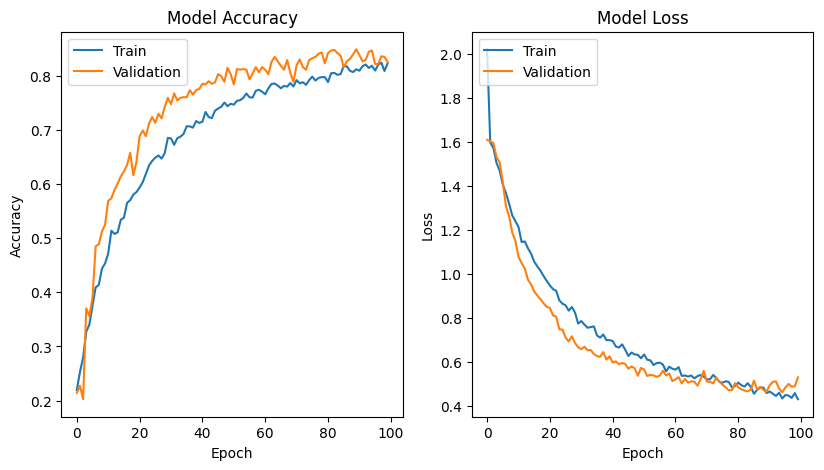

In [39]:


## 6. Visualize Results

# Plot training history and confusion matrix.

# Plot training & validation accuracy values
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history: # Check if validation accuracy exists
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history: # Check if validation loss exists
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")


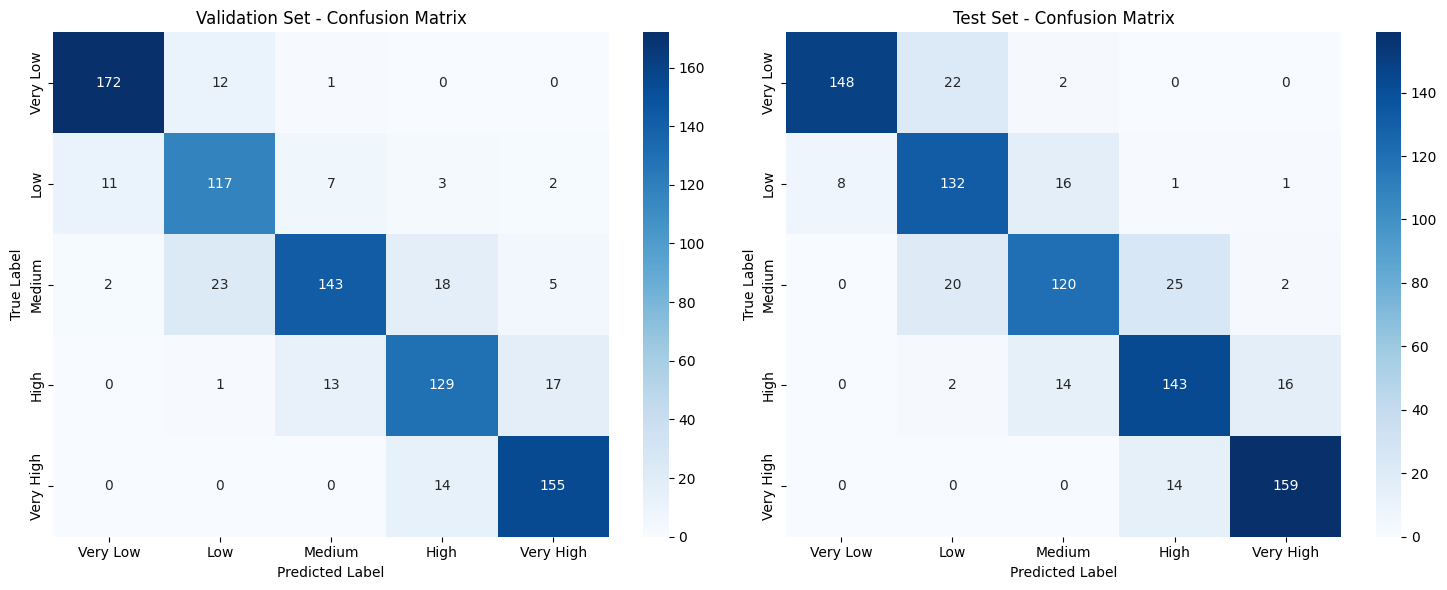

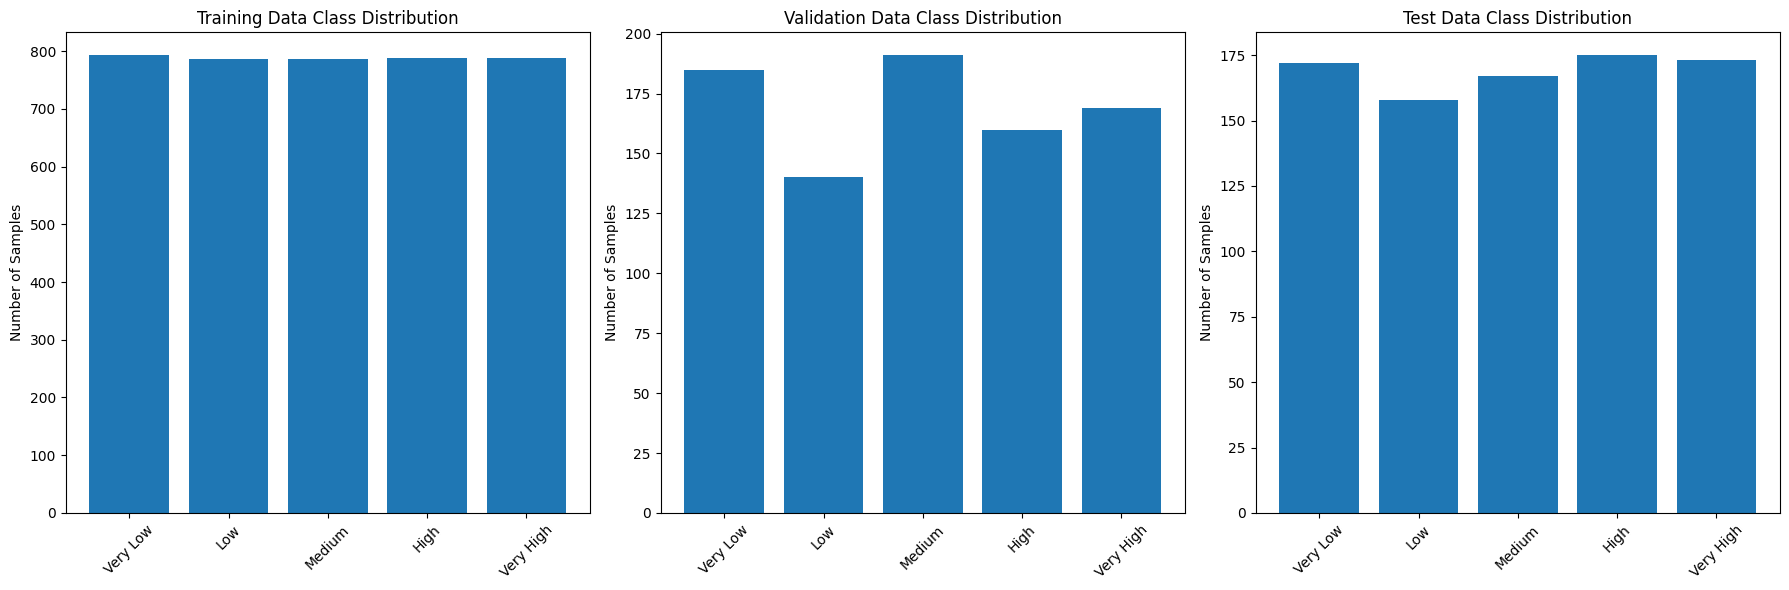

In [40]:


# Plot Confusion Matrices for both Validation and Test sets
plt.figure(figsize=(15, 6))
# Validation Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_detailed,
            yticklabels=class_names_detailed)
plt.title("Validation Set - Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Test Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_detailed,
            yticklabels=class_names_detailed)
plt.title("Test Set - Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()


# Plot class distribution comparison
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(class_names_detailed, class_counts)
plt.title("Training Data Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
y_val_counts = np.bincount(y_val_labels)
plt.bar(class_names_detailed, y_val_counts)
plt.title("Validation Data Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
y_test_counts = np.bincount(y_test_labels)
plt.bar(class_names_detailed, y_test_counts)
plt.title("Test Data Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [41]:


# Summary comparison table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY COMPARISON")
print("="*80)
print(f"{'Metric':<25} {'Validation':<15} {'Test':<15}")
print("-" * 55)
print(f"{'Accuracy':<25} {val_accuracy:<15.4f} {accuracy:<15.4f}")
print(f"{'Macro F1 Score':<25} {val_macro_f1:<15.4f} {macro_f1:<15.4f}")
print(f"{'Weighted F1 Score':<25} {val_weighted_f1:<15.4f} {weighted_f1:<15.4f}")
print(f"{'Loss':<25} {val_loss:<15.4f} {loss:<15.4f}")

print(f"\nQuantile boundaries used for classification:")
for i in range(len(quantile_bins)-1):
    if i == 0:
        print(f"{class_names_detailed[i]}: < {quantile_bins[i+1]:.2f}")
    elif i == len(quantile_bins)-2:
        print(f"{class_names_detailed[i]}: >= {quantile_bins[i]:.2f}")
    else:
        print(f"{class_names_detailed[i]}: {quantile_bins[i]:.2f} - {quantile_bins[i+1]:.2f}")

print("\n--- End of Script ---")


PERFORMANCE SUMMARY COMPARISON
Metric                    Validation      Test           
-------------------------------------------------------
Accuracy                  0.8473          0.8308         
Macro F1 Score            0.8442          0.8300         
Weighted F1 Score         0.8469          0.8311         
Loss                      0.4606          0.4756         

Quantile boundaries used for classification:
Very Low: < 578.00
Low: 578.00 - 1463.00
Medium: 1463.00 - 3119.52
High: 3119.52 - 6540.92
Very High: >= 6540.92

--- End of Script ---
